### Import libraries

In [166]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from pyproj import Proj
import matplotlib.pyplot as plt

### Read files

In [167]:
# change to LA
city_name = 'Memphis'

# Below is the Google File Drive Stream pathway for a mac. 
input_path = '/Volumes/GoogleDrive/My Drive/CCI Docs/Current Projects/SPARCC/Data/Inputs/'
output_path = '~/git/sparcc/data/'
shp_folder = input_path+'shp/'+city_name+'/'

data_1990 = pd.read_csv(output_path+city_name+'census_90_10.csv', index_col = 0) 
data_2000 = pd.read_csv(output_path+city_name+'census_00_10.csv', index_col = 0)
acs_data = pd.read_csv(output_path+city_name+'census_summ.csv', index_col = 0)

acs_data = acs_data.drop(columns = ['county_y', 'state_y', 'tract_y'])
acs_data = acs_data.rename(columns = {'county_x': 'county',
                                    'state_x': 'state',
                                    'tract_x': 'tract'})


### PUMS
pums_r = pd.read_csv(input_path+'nhgis0002_ds233_20175_2017_tract.csv', encoding = "ISO-8859-1")
pums_o = pd.read_csv(input_path+'nhgis0002_ds234_20175_2017_tract.csv', encoding = "ISO-8859-1")
pums = pums_r.merge(pums_o, on = 'GISJOIN')
pums = pums.rename(columns = {'YEAR_x':'YEAR',
                               'STATE_x':'STATE',
                               'STATEA_x':'STATEA',
                               'COUNTY_x':'COUNTY',
                               'COUNTYA_x':'COUNTYA',
                               'TRACTA_x':'TRACTA',
                               'NAME_E_x':'NAME_E'})
pums = pums.dropna(axis = 1)


### Zillow data
zillow = pd.read_csv(input_path+'Zip_Zhvi_AllHomes.csv', encoding = "ISO-8859-1")
zillow_xwalk = pd.read_csv(input_path+'TRACT_ZIP_032015.csv')

### Rail data
rail = pd.read_csv(input_path+'tod_database_download.csv')

### Hospitals
hospitals = pd.read_csv(input_path+'Hospitals.csv')

### Universities
university = pd.read_csv(input_path+'university_HD2016.csv')
### LIHTC
lihtc = pd.read_csv(input_path+'LowIncome_Housing_Tax_Credit_Properties.csv')

### Public housing
pub_hous = pd.read_csv(input_path+'Public_Housing_Buildings.csv')

### SHP data
if city_name == 'Memphis':
    shp_name = 'cb_2017_47_tract_500k.shp'
elif city_name == 'Chicago':
    shp_name = 'cb_2017_17_tract_500k.shp'
elif city_name == 'Atlanta':
    shp_name = 'cb_2017_13_tract_500k.shp'
elif city_name == 'Denver':
    shp_name = 'cb_2017_08_tract_500k.shp'
city_shp = gpd.read_file(shp_folder+shp_name)

/Users/timothythomas/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (90,98,103,109,110,113,114) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/timothythomas/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (99,104,109) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Choose city and define city specific variables

In [168]:
if city_name == 'Chicago':
    state = '17'
    state_init = ['IL']
    FIPS = ['031', '043', '089', '093', '097', '111', '197']
    rail_agency = 'CTA'
    zone = '16T'
    
# Add LA elif
elif city_name == 'Atlanta':
    state = '13'
    state_init = ['GA']
    FIPS = ['057', '063', '067', '089', '097', '113', '121', '135', '151', '247']
    rail_agency = 'MARTA'
    zone = '16S'
    
elif city_name == 'Denver':
    state = '08'
    state_init = ['CO']
    FIPS = ['001', '005', '013', '014', '019', '031', '035', '047', '059']
    rail_agency = 'RTD'
    zone = '13S'
    
elif city_name == 'Memphis':
    state = ['28', '47']
    state_init = ['MS', 'TN']
    FIPS = {'28':['033', '093'], '47': ['047', '157']}
    rail_agency = np.nan
    zone = '15S'
    
else:
    print ('There is no information for the selected city')

### Merge census data in single file

In [169]:
census = acs_data.merge(data_2000, on = 'FIPS', how = 'outer').merge(data_1990, on = 'FIPS', how = 'outer')

### Compute census variables

#### CPI indexing values

In [170]:
### This is based on the yearly CPI average
CPI_89_17 = 1.977
CPI_99_17 = 1.472

### This is used for the Zillow data, where january values are compared
CPI_0115_0119 = 1.077

#### Income

In [171]:
census['hinc_17'][census['hinc_17']<0]=np.nan
census['hinc_00'][census['hinc_00']<0]=np.nan
census['hinc_90'][census['hinc_90']<0]=np.nan

/Users/timothythomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/timothythomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/timothythomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Thi

In [172]:
### These are not indexed
rm_hinc_17 = np.nanmedian(census['hinc_17'])
rm_hinc_00 = np.nanmedian(census['hinc_00'])
rm_hinc_90 = np.nanmedian(census['hinc_90'])

rm_iinc_17 = np.nanmedian(census['iinc_17'])
rm_iinc_12 = np.nanmedian(census['iinc_12'])

print(rm_hinc_17, rm_hinc_00, rm_hinc_90, rm_iinc_17, rm_iinc_12)

43837.0 30924.5 17994.57241699071 24548.0 24146.0


In [173]:
def income_interpolation (census, year, cutoff, mhinc, tot_var, var_suffix, out):
    
    name = []
    for c in list(census.columns):
        if (c[0]==var_suffix):
            if c.split('_')[2]==year:
                name.append(c)
    name.append('FIPS')
    name.append(tot_var)
    
    income_cat = census[name]
    income_group = income_cat.drop(columns = ['FIPS', tot_var]).columns
    income_group = income_group.str.split('_')
    number = []
    for i in range (0, len(income_group)):
        number.append(income_group[i][1])

    column = []
    for i in number:
        column.append('prop_'+str(i))
        income_cat['prop_'+str(i)] = income_cat[var_suffix+'_'+str(i)+'_'+year]/income_cat[tot_var]
             
    reg_median_cutoff = cutoff*mhinc
    cumulative = out+str(int(cutoff*100))+'_cumulative'
    income = out+str(int(cutoff*100))+'_'+year
    
    df = income_cat
    df[cumulative] = 0
    df[income] = 0

    for i in range(0,(len(number)-1)):
        a = (number[i])
        b = float(number[i+1])-0.01
        prop = str(number[i+1])

        df[cumulative] = df[cumulative]+df['prop_'+a]

        if (reg_median_cutoff>=int(a))&(reg_median_cutoff<b):
            df[income] = ((reg_median_cutoff - int(a))/(b-int(a)))*df['prop_'+prop] + df[cumulative]
    
    df = df.drop(columns = [cumulative])
    prop_col = df.columns[df.columns.str[0:4]=='prop'] 
    df = df.drop(columns = prop_col)     

    census = census.merge (df[['FIPS', income]], on = 'FIPS')
    return census

In [174]:
census = income_interpolation (census, '17', 0.8, rm_hinc_17, 'hh_17', 'I', 'inc')
census =income_interpolation (census, '17', 1.2, rm_hinc_17, 'hh_17', 'I', 'inc')
census = income_interpolation (census, '00', 0.8, rm_hinc_00, 'hh_00', 'I', 'inc')
census =income_interpolation (census, '00', 1.2, rm_hinc_00, 'hh_00', 'I', 'inc')
census = income_interpolation (census, '90', 0.8, rm_hinc_90, 'hh_00', 'I', 'inc')

income_col = census.columns[census.columns.str[0:2]=='I_'] 
census = census.drop(columns = income_col)

/Users/timothythomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/timothythomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/timothythomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

###### Generate income categories

In [175]:
def income_categories (df, year, mhinc, hinc):

    df['hinc_'+year] = np.where(df['hinc_'+year]<0, 0, df['hinc_'+year])
    
    reg_med_inc80 = 0.8*mhinc
    reg_med_inc120 = 1.2*mhinc
    
    low = 'low_80120_'+year 
    mod = 'mod_80120_'+year
    high = 'high_80120_'+year

    df[low] = df['inc80_'+year]
    df[mod] = df['inc120_'+year] - df['inc80_'+year]
    df[high] = 1 - df['inc120_'+year]
    
    ### Low income
    df['low_pdmt_medhhinc_'+year] = np.where((df['low_80120_'+year]>=0.55)&(df['mod_80120_'+year]<0.45)&(df['high_80120_'+year]<0.45),1,0)

    ## High income
    df['high_pdmt_medhhinc_'+year] = np.where((df['low_80120_'+year]<0.45)&(df['mod_80120_'+year]<0.45)&(df['high_80120_'+year]>=0.55),1,0)

    ### Moderate income
    df['mod_pdmt_medhhinc_'+year] = np.where((df['low_80120_'+year]<0.45)&(df['mod_80120_'+year]>=0.55)&(df['high_80120_'+year]<0.45),1,0)

    ### Mixed-Low income
    df['mix_low_medhhinc_'+year] = np.where((df['low_pdmt_medhhinc_'+year]==0)&
                                                  (df['mod_pdmt_medhhinc_'+year]==0)&
                                                  (df['high_pdmt_medhhinc_'+year]==0)&
                                                  (df[hinc]<reg_med_inc80),1,0)

    ### Mixed-Moderate income
    df['mix_mod_medhhinc_'+year] = np.where((df['low_pdmt_medhhinc_'+year]==0)&
                                                  (df['mod_pdmt_medhhinc_'+year]==0)&
                                                  (df['high_pdmt_medhhinc_'+year]==0)&
                                                  (df[hinc]>=reg_med_inc80)&
                                                  (df[hinc]<reg_med_inc120),1,0)

    ### Mixed-High income
    df['mix_high_medhhinc_'+year] = np.where((df['low_pdmt_medhhinc_'+year]==0)&
                                                  (df['mod_pdmt_medhhinc_'+year]==0)&
                                                  (df['high_pdmt_medhhinc_'+year]==0)&
                                                  (df[hinc]>=reg_med_inc120),1,0)
    
    df['inc_cat_medhhinc_'+year] = 0
    df.loc[df['low_pdmt_medhhinc_'+year]==1, 'inc_cat_medhhinc_'+year] = 1
    df.loc[df['mix_low_medhhinc_'+year]==1, 'inc_cat_medhhinc_'+year] = 2
    df.loc[df['mod_pdmt_medhhinc_'+year]==1, 'inc_cat_medhhinc_'+year] = 3
    df.loc[df['mix_mod_medhhinc_'+year]==1, 'inc_cat_medhhinc_'+year] = 4
    df.loc[df['mix_high_medhhinc_'+year]==1, 'inc_cat_medhhinc_'+year] = 5
    df.loc[df['high_pdmt_medhhinc_'+year]==1, 'inc_cat_medhhinc_'+year] = 6
    
    df['inc_cat_medhhinc_encoded'+year] = 0
    df.loc[df['low_pdmt_medhhinc_'+year]==1, 'inc_cat_medhhinc_encoded'+year] = 'low_pdmt'
    df.loc[df['mix_low_medhhinc_'+year]==1, 'inc_cat_medhhinc_encoded'+year] = 'mix_low'
    df.loc[df['mod_pdmt_medhhinc_'+year]==1, 'inc_cat_medhhinc_encoded'+year] = 'mod_pdmt'
    df.loc[df['mix_mod_medhhinc_'+year]==1, 'inc_cat_medhhinc_encoded'+year] = 'mix_mod'
    df.loc[df['mix_high_medhhinc_'+year]==1, 'inc_cat_medhhinc_encoded'+year] = 'mix_high'
    df.loc[df['high_pdmt_medhhinc_'+year]==1, 'inc_cat_medhhinc_encoded'+year] = 'high_pdmt'

    
    df.loc[df['hinc_'+year]==0, 'low_pdmt_medhhinc_'+year] = np.nan
    df.loc[df['hinc_'+year]==0, 'mix_low_medhhinc_'+year] = np.nan
    df.loc[df['hinc_'+year]==0, 'mod_pdmt_medhhinc_'+year] = np.nan
    df.loc[df['hinc_'+year]==0, 'mix_mod_medhhinc_'+year] = np.nan
    df.loc[df['hinc_'+year]==0, 'mix_high_medhhinc_'+year] = np.nan
    df.loc[df['hinc_'+year]==0, 'high_pdmt_medhhinc_'+year] = np.nan
    df.loc[df['hinc_'+year]==0, 'inc_cat_medhhinc_'+year] = np.nan
    
    return census

In [176]:
census = income_categories(census, '17', rm_hinc_17, 'hinc_17')
census = income_categories(census, '00', rm_hinc_00, 'hinc_00')

In [177]:
census.groupby('inc_cat_medhhinc_00').count()['FIPS']

inc_cat_medhhinc_00
0.0      1
1.0     39
2.0     23
4.0     57
5.0     14
6.0    137
Name: FIPS, dtype: int64

In [178]:
census.groupby('inc_cat_medhhinc_17').count()['FIPS']

inc_cat_medhhinc_17
0.0     5
1.0    81
2.0    14
4.0    66
5.0    10
6.0    95
Name: FIPS, dtype: int64

In [179]:
### Percentage & total low-income households - under 80% AMI
census ['per_all_li_90'] = census['inc80_90']
census ['per_all_li_00'] = census['inc80_00']
census ['per_all_li_17'] = census['inc80_17']

census['all_li_count_90'] = census['per_all_li_90']*census['hh_90']
census['all_li_count_00'] = census['per_all_li_00']*census['hh_00']
census['all_li_count_17'] = census['per_all_li_17']*census['hh_17']

#### Index all values to 2017

In [180]:
census['real_mhval_90'] = census['mhval_90']*CPI_89_17
census['real_mrent_90'] = census['mrent_90']*CPI_89_17
census['real_hinc_90'] = census['hinc_90']*CPI_89_17

census['real_mhval_00'] = census['mhval_00']*CPI_99_17
census['real_mrent_00'] = census['mrent_00']*CPI_99_17
census['real_hinc_00'] = census['hinc_00']*CPI_99_17

census['real_mhval_17'] = census['mhval_17']
census['real_mrent_17'] = census['mrent_17']
census['real_hinc_17'] = census['hinc_17']

#### Demographics

In [181]:
df = census

### % of non-white

###
df['per_nonwhite_17'] = 1 - df['white_17']/df['pop_17']

### 1990
df['per_nonwhite_90'] = 1 - df['white_90']/df['pop_90']

### 2000
df['per_nonwhite_00'] = 1 - df['white_00']/df['pop_00']


### % of owner and renter-occupied housing units
### 1990
df['hu_90'] = df['ohu_90']+df['rhu_90']
df['per_rent_90'] = df['rhu_90']/df['hu_90']

### 2000
df['per_rent_00'] = df['rhu_00']/df['hu_00']


### % of college educated

### 1990
var_list = ['total_25_col_9th_90',
            'total_25_col_12th_90',
            'total_25_col_hs_90',
            'total_25_col_sc_90',
            'total_25_col_ad_90',
            'total_25_col_bd_90',
            'total_25_col_gd_90']
df['total_25_90'] = df[var_list].sum(axis = 1)
df['per_col_90'] = (df['total_25_col_bd_90']+df['total_25_col_gd_90'])/(df['total_25_90'])

### 2000
df['male_25_col_00'] = (df['male_25_col_bd_00']+
                        df['male_25_col_md_00']+
#                         df['male_25_col_psd_00']+
                        df['male_25_col_phd_00'])
df['female_25_col_00'] = (df['female_25_col_bd_00']+
                          df['female_25_col_md_00']+
#                           df['female_25_col_psd_00']+
                          df['female_25_col_phd_00'])
df['total_25_col_00'] = df['male_25_col_00']+df['female_25_col_00']
df['per_col_00'] = df['total_25_col_00']/df['total_25_00']

### 2017
df['per_col_17'] = (df['total_25_col_bd_17']+
                    df['total_25_col_md_17']+
                    df['total_25_col_pd_17']+
                    df['total_25_col_phd_17'])/df['total_25_17']

### Housing units built
df['per_units_pre50_17'] = (df['units_40_49_built_17']+df['units_39_early_built_17'])/df['tot_units_built_17']

#### Percent of people who have moved who are low-income

In [182]:
def income_interpolation_movein (census, year, cutoff, rm_iinc):
    
    # SUM EVERY CATEGORY BY INCOME

    ### Filter only move-in variables
    name = []
    for c in list(census.columns):
        if (c[0:3] == 'mov') & (c[-2:]==year):
            name.append(c)
    name.append('FIPS')
    income_cat = census[name]

    ### Pull income categories
    income_group = income_cat.drop(columns = ['FIPS']).columns
    number = []
    for c in name[:9]:
        number.append(c.split('_')[2])

    ### Sum move-in in last 5 years by income category, including total w/ income
    column_name_totals = []
    for i in number:
        column_name = []
        for j in income_group:
            if j.split('_')[2] == i:
                column_name.append(j)
        if i == 'w':
            i = 'w_income'
        income_cat['mov_tot_'+i+'_'+year] = income_cat[column_name].sum(axis = 1)
        column_name_totals.append('mov_tot_'+i+'_'+year)

    # DO INCOME INTERPOLATION
    column = []
    number = [n for n in number if n != 'w'] ### drop total
    for i in number:
        column.append('prop_mov_'+i)
        income_cat['prop_mov_'+i] = income_cat['mov_tot_'+i+'_'+year]/income_cat['mov_tot_w_income_'+year]


    reg_median_cutoff = cutoff*rm_iinc
    cumulative = 'inc'+str(int(cutoff*100))+'_cumulative'
    per_limove = 'per_limove_'+year

    df = income_cat
    df[cumulative] = 0
    df[per_limove] = 0

    for i in range(0,(len(number)-1)):
        a = (number[i])
        b = float(number[i+1])-0.01
        prop = str(number[i+1])

        df[cumulative] = df[cumulative]+df['prop_mov_'+a]

        if (reg_median_cutoff>=int(a))&(reg_median_cutoff<b):
            df[per_limove] = ((reg_median_cutoff - int(a))/(b-int(a)))*df['prop_mov_'+prop] + df[cumulative]
            
    df = df.drop(columns = [cumulative])
    prop_col = df.columns[df.columns.str[0:4]=='prop'] 
    df = df.drop(columns = prop_col)     

    col_list = [per_limove]+['mov_tot_w_income_'+year]
    census = census.merge (df[['FIPS'] + col_list], on = 'FIPS')
    return census

In [183]:
census = income_interpolation_movein (census, '17', 0.8, rm_iinc_17)
census = income_interpolation_movein (census, '12', 0.8, rm_iinc_12)

/Users/timothythomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/timothythomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/timothythomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

#### Housing Affordability

In [184]:
def filter_PUMS(df, FIPS):
    if city_name != 'Memphis':
        FIPS = [int(x) for x in FIPS]
        df = df[(df['STATEA'] == int(state))&(df['COUNTYA'].isin(FIPS))].reset_index(drop = True)

    else:
        fips_list = []
        for i in state:
            county = FIPS[i]
            county = [int(x) for x in county]
            a = list((df['GISJOIN'][(pums['STATEA']==int(i))&(df['COUNTYA'].isin(county))]))
            fips_list += a
        df = df[df['GISJOIN'].isin(fips_list)].reset_index(drop = True)
    return df

In [185]:
pums = filter_PUMS(pums, FIPS)
pums['FIPS'] = ((pums['STATEA'].astype(str).str.zfill(2))+
                (pums['COUNTYA'].astype(str).str.zfill(3))+
                (pums['TRACTA'].astype(str).str.zfill(6)))

In [186]:
pums = pums.rename(columns = {"AH5QE002":"rhu_17_wcash",
                                "AH5QE003":"R_100_17",
                                "AH5QE004":"R_150_17",
                                "AH5QE005":"R_200_17",
                                "AH5QE006":"R_250_17",
                                "AH5QE007":"R_300_17",
                                "AH5QE008":"R_350_17",
                                "AH5QE009":"R_400_17",
                                "AH5QE010":"R_450_17",
                                "AH5QE011":"R_500_17",
                                "AH5QE012":"R_550_17",
                                "AH5QE013":"R_600_17",
                                "AH5QE014":"R_650_17",
                                "AH5QE015":"R_700_17",
                                "AH5QE016":"R_750_17",
                                "AH5QE017":"R_800_17",
                                "AH5QE018":"R_900_17",
                                "AH5QE019":"R_1000_17",
                                "AH5QE020":"R_1250_17",
                                "AH5QE021":"R_1500_17",
                                "AH5QE022":"R_2000_17",
                                "AH5QE023":"R_2500_17",
                                "AH5QE024":"R_3000_17",
                                "AH5QE025":"R_3500_17",
                                "AH5QE026":"R_3600_17",
                                "AH5QE027":"rhu_17_wocash",
                                "AIMUE001":"ohu_tot_17",
                                "AIMUE002":"O_200_17",
                                "AIMUE003":"O_300_17",
                                "AIMUE004":"O_400_17",
                                "AIMUE005":"O_500_17",
                                "AIMUE006":"O_600_17",
                                "AIMUE007":"O_700_17",
                                "AIMUE008":"O_800_17",
                                "AIMUE009":"O_900_17",
                                "AIMUE010":"O_1000_17",
                                "AIMUE011":"O_1250_17",
                                "AIMUE012":"O_1500_17",
                                "AIMUE013":"O_2000_17",
                                "AIMUE014":"O_2500_17",
                                "AIMUE015":"O_3000_17",
                                "AIMUE016":"O_3500_17",
                                "AIMUE017":"O_4000_17",
                                "AIMUE018":"O_4100_17"})

In [187]:
aff_17 = rm_hinc_17*0.3/12
pums = income_interpolation (pums, '17', 0.6, aff_17, 'rhu_17_wcash', 'R', 'rent')
pums = income_interpolation (pums, '17', 1.2, aff_17, 'rhu_17_wcash', 'R', 'rent')

pums = income_interpolation (pums, '17', 0.6, aff_17, 'ohu_tot_17', 'O', 'own')
pums = income_interpolation (pums, '17', 1.2, aff_17, 'ohu_tot_17', 'O', 'own')

/Users/timothythomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/timothythomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/timothythomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [188]:
pums['FIPS'] = pums['FIPS'].astype(float).astype('int64')
pums = pums.merge(census[['FIPS', 'mmhcosts_17']], on = 'FIPS')

pums['rlow_17'] = pums['rent60_17']*pums['rhu_17_wcash']+pums['rhu_17_wocash'] ### includes no cash rent
pums['rmod_17'] = pums['rent120_17']*pums['rhu_17_wcash']-pums['rent60_17']*pums['rhu_17_wcash']
pums['rhigh_17'] = pums['rhu_17_wcash']-pums['rent120_17']*pums['rhu_17_wcash']

pums['olow_17'] = pums['own60_17']*pums['ohu_tot_17']
pums['omod_17'] = pums['own120_17']*pums['ohu_tot_17'] - pums['own60_17']*pums['ohu_tot_17']
pums['ohigh_17'] = pums['ohu_tot_17'] - pums['own120_17']*pums['ohu_tot_17']

pums['hu_tot_17'] = pums['rhu_17_wcash']+pums['rhu_17_wocash']+pums['ohu_tot_17']

pums['low_tot_17'] = pums['rlow_17']+pums['olow_17']
pums['mod_tot_17'] = pums['rmod_17']+pums['omod_17']
pums['high_tot_17'] = pums['rhigh_17']+pums['ohigh_17']

pums['pct_low_17'] = pums['low_tot_17']/pums['hu_tot_17']
pums['pct_mod_17'] = pums['mod_tot_17']/pums['hu_tot_17']
pums['pct_high_17'] = pums['high_tot_17']/pums['hu_tot_17']


### Low income
pums['predominantly_LI'] = np.where((pums['pct_low_17']>=0.55)&
                                       (pums['pct_mod_17']<0.45)&
                                       (pums['pct_high_17']<0.45),1,0)

## High income
pums['predominantly_HI'] = np.where((pums['pct_low_17']<0.45)&
                                       (pums['pct_mod_17']<0.45)&
                                       (pums['pct_high_17']>=0.55),1,0)

### Moderate income
pums['predominantly_MI'] = np.where((pums['pct_low_17']<0.45)&
                                       (pums['pct_mod_17']>=0.55)&
                                       (pums['pct_high_17']<0.45),1,0)

### Mixed-Low income
pums['mixed_low'] = np.where((pums['predominantly_LI']==0)&
                              (pums['predominantly_MI']==0)&
                              (pums['predominantly_HI']==0)&
                              (pums['mmhcosts_17']<aff_17*0.6),1,0)

### Mixed-Moderate income
pums['mixed_mod'] = np.where((pums['predominantly_LI']==0)&
                              (pums['predominantly_MI']==0)&
                              (pums['predominantly_HI']==0)&
                              (pums['mmhcosts_17']>=aff_17*0.6)&
                              (pums['mmhcosts_17']<aff_17*1.2),1,0)

### Mixed-High income
pums['mixed_high'] = np.where((pums['predominantly_LI']==0)&
                              (pums['predominantly_MI']==0)&
                              (pums['predominantly_HI']==0)&
                              (pums['mmhcosts_17']>=aff_17*1.2),1,0)

pums['lmh_flag_encoded'] = 0
pums.loc[pums['predominantly_LI']==1, 'lmh_flag_encoded'] = 1
pums.loc[pums['predominantly_MI']==1, 'lmh_flag_encoded'] = 2
pums.loc[pums['predominantly_HI']==1, 'lmh_flag_encoded'] = 3
pums.loc[pums['mixed_low']==1, 'lmh_flag_encoded'] = 4
pums.loc[pums['mixed_mod']==1, 'lmh_flag_encoded'] = 5
pums.loc[pums['mixed_high']==1, 'lmh_flag_encoded'] = 6

pums['lmh_flag_category'] = 0
pums.loc[pums['lmh_flag_encoded']==1, 'lmh_flag_category'] = 'aff_predominantly_LI'
pums.loc[pums['lmh_flag_encoded']==2, 'lmh_flag_category'] = 'aff_predominantly_MI'
pums.loc[pums['lmh_flag_encoded']==3, 'lmh_flag_category'] = 'aff_predominantly_HI'
pums.loc[pums['lmh_flag_encoded']==4, 'lmh_flag_category'] = 'aff_mix_low'
pums.loc[pums['lmh_flag_encoded']==5, 'lmh_flag_category'] = 'aff_mix_mod'
pums.loc[pums['lmh_flag_encoded']==6, 'lmh_flag_category'] = 'aff_mix_high'

In [189]:
pums.groupby('lmh_flag_category').count()['FIPS']

lmh_flag_category
aff_mix_high              8
aff_mix_low              13
aff_mix_mod             119
aff_predominantly_HI     21
aff_predominantly_LI     28
aff_predominantly_MI     82
Name: FIPS, dtype: int64

In [190]:
census = census.merge(pums[['FIPS', 'lmh_flag_encoded', 'lmh_flag_category']], on = 'FIPS')

#### Market Type

In [191]:
census['pctch_real_mhval_00_17'] = (census['real_mhval_17']-census['real_mhval_00'])/census['real_mhval_00']
census['pctch_real_mrent_00_17'] = (census['real_mrent_17']-census['real_mrent_00'])/census['real_mrent_00']

rm_pctch_real_mhval_00_17_increase=np.nanmedian(census['pctch_real_mhval_00_17'][census['pctch_real_mhval_00_17']>0.05])
rm_pctch_real_mrent_00_17_increase=np.nanmedian(census['pctch_real_mrent_00_17'][census['pctch_real_mrent_00_17']>0.05])

# rm_pctch_real_mhval_00_17_increase=np.nanmedian(census['pctch_real_mhval_00_17'])
# rm_pctch_real_mrent_00_17_increase=np.nanmedian(census['pctch_real_mrent_00_17'])

In [192]:
census['rent_decrease'] = np.where((census['pctch_real_mrent_00_17']<=-0.05), 1, 0)

census['rent_marginal'] = np.where((census['pctch_real_mrent_00_17']>-0.05)&
                                          (census['pctch_real_mrent_00_17']<0.05), 1, 0)

census['rent_increase'] = np.where((census['pctch_real_mrent_00_17']>=0.05)&
                                          (census['pctch_real_mrent_00_17']<rm_pctch_real_mrent_00_17_increase), 1, 0)

census['rent_rapid_increase'] = np.where((census['pctch_real_mrent_00_17']>=0.05)&
                                          (census['pctch_real_mrent_00_17']>=rm_pctch_real_mrent_00_17_increase), 1, 0)


census['house_decrease'] = np.where((census['pctch_real_mhval_00_17']<=-0.05), 1, 0)

census['house_marginal'] = np.where((census['pctch_real_mhval_00_17']>-0.05)&
                                          (census['pctch_real_mhval_00_17']<0.05), 1, 0)

census['house_increase'] = np.where((census['pctch_real_mhval_00_17']>=0.05)&
                                          (census['pctch_real_mhval_00_17']<rm_pctch_real_mhval_00_17_increase), 1, 0)

census['house_rapid_increase'] = np.where((census['pctch_real_mhval_00_17']>=0.05)&
                                          (census['pctch_real_mhval_00_17']>=rm_pctch_real_mhval_00_17_increase), 1, 0)

census['tot_decrease'] = np.where((census['rent_decrease']==1)|(census['house_decrease']), 1, 0)
census['tot_marginal'] = np.where((census['rent_marginal']==1)|(census['house_marginal']), 1, 0)
census['tot_increase'] = np.where((census['rent_increase']==1)|(census['house_increase']), 1, 0)
census['tot_rapid_increase'] = np.where((census['rent_rapid_increase']==1)|(census['house_rapid_increase']), 1, 0)

census['change_flag_encoded'] = 0
census.loc[(census['tot_decrease']==1)|(census['tot_marginal']==1), 'change_flag_encoded'] = 1
census.loc[census['tot_increase']==1, 'change_flag_encoded'] = 2
census.loc[census['tot_rapid_increase']==1, 'change_flag_encoded'] = 3

census['change_flag_category'] = 0
census.loc[census['change_flag_encoded']==1, 'change_flag_category'] = 'ch_decrease_marginal'
census.loc[census['change_flag_encoded']==2, 'change_flag_category'] = 'ch_increase'
census.loc[census['change_flag_encoded']==3, 'change_flag_category'] = 'ch_rapid_increase'

In [193]:
census.groupby('change_flag_category').count()['FIPS']

change_flag_category
0                        1
ch_decrease_marginal    98
ch_increase             86
ch_rapid_increase       86
Name: FIPS, dtype: int64

In [194]:
census.groupby(['change_flag_category', 'lmh_flag_category']).count()['FIPS']

change_flag_category  lmh_flag_category   
0                     aff_mix_low              1
ch_decrease_marginal  aff_mix_high             3
                      aff_mix_low              5
                      aff_mix_mod             32
                      aff_predominantly_HI     7
                      aff_predominantly_LI    14
                      aff_predominantly_MI    37
ch_increase           aff_mix_high             2
                      aff_mix_low              4
                      aff_mix_mod             41
                      aff_predominantly_HI     6
                      aff_predominantly_LI    11
                      aff_predominantly_MI    22
ch_rapid_increase     aff_mix_high             3
                      aff_mix_low              3
                      aff_mix_mod             46
                      aff_predominantly_HI     8
                      aff_predominantly_LI     3
                      aff_predominantly_MI    23
Name: FIPS, dtype: int64

###### Load Zillow data

In [195]:
def filter_ZILLOW(df, FIPS):
    if city_name != 'Memphis':
        FIPS_pre = [state+county for county in FIPS]
        df = df[(df['FIPS'].astype(str).str.zfill(11).str[:5].isin(FIPS_pre))].reset_index(drop = True)

    else:
        fips_list = []
        for i in state:
            county = FIPS[str(i)]
            FIPS_pre = [str(i)+county for county in county]         
        df = df[(df['FIPS'].astype(str).str.zfill(11).str[:5].isin(FIPS_pre))].reset_index(drop = True)
    return df

In [196]:
### Zillow data
zillow = pd.read_csv(input_path+'Zip_Zhvi_AllHomes.csv', encoding = "ISO-8859-1")
zillow_xwalk = pd.read_csv(input_path+'TRACT_ZIP_032015.csv')

## Compute change over time
zillow['ch_zillow_15_19'] = zillow['2019-01'] - zillow['2015-01']*CPI_0115_0119
zillow['per_ch_zillow_15_19'] = zillow['ch_zillow_15_19']/zillow['2015-01']
zillow = zillow[zillow['State'].isin(state_init)].reset_index(drop = True)
zillow = zillow_xwalk[['TRACT', 'ZIP', 'RES_RATIO']].merge(zillow[['RegionName', 'ch_zillow_15_19', 'per_ch_zillow_15_19']], left_on = 'ZIP', right_on = 'RegionName', how = 'outer')
zillow = zillow.rename(columns = {'TRACT':'FIPS'})

# Filter only data of interest
zillow = filter_ZILLOW(zillow, FIPS)

### Keep only data for largest xwalk value, based on residential ratio
zillow = zillow.sort_values(by = ['FIPS', 'RES_RATIO'], ascending = False).groupby('FIPS').first().reset_index(drop = False)

### Compute 90th percentile change in region
percentile_90 = zillow['per_ch_zillow_15_19'].quantile(q = 0.9)
print(percentile_90)

### Create flags
### Change over 50% of change in region
zillow['ab_50pct_ch'] = np.where(zillow['per_ch_zillow_15_19']>0.5, 1, 0)
### Change over 90th percentile change
zillow['ab_90percentile_ch'] = np.where(zillow['per_ch_zillow_15_19']>percentile_90, 1, 0)

census = census.merge(zillow[['FIPS', 'ab_50pct_ch', 'ab_90percentile_ch']], on = 'FIPS')

0.4168271604938272


#### Regional medians

In [197]:
rm_per_all_li_90 = np.nanmedian(census['per_all_li_90'])
rm_per_all_li_00 = np.nanmedian(census['per_all_li_00'])
rm_per_nonwhite_90 = np.nanmedian(census['per_nonwhite_90'])
rm_per_nonwhite_00 = np.nanmedian(census['per_nonwhite_00'])
rm_per_nonwhite_17 = np.nanmedian(census['per_nonwhite_17'])
rm_per_col_90 = np.nanmedian(census['per_col_90'])
rm_per_col_00 = np.nanmedian(census['per_col_00'])
rm_per_col_17 = np.nanmedian(census['per_col_17'])
rm_per_rent_90= np.nanmedian(census['per_rent_90'])
rm_per_rent_00= np.nanmedian(census['per_rent_00'])
rm_real_mrent_90 = np.nanmedian(census['real_mrent_90'])
rm_real_mrent_00 = np.nanmedian(census['real_mrent_00'])
rm_real_mrent_17 = np.nanmedian(census['real_mrent_17'])
rm_real_mhval_90 = np.nanmedian(census['real_mhval_90'])
rm_real_mhval_00 = np.nanmedian(census['real_mhval_00'])
rm_real_mhval_17 = np.nanmedian(census['real_mhval_17'])
rm_real_hinc_90 = np.nanmedian(census['real_hinc_90'])
rm_real_hinc_00 = np.nanmedian(census['real_hinc_00'])
rm_real_hinc_17 = np.nanmedian(census['real_hinc_17'])
rm_per_units_pre50_17 = np.nanmedian(census['per_units_pre50_17'])

#### Percent changes

In [198]:
census['pctch_real_mhval_90_00'] = (census['real_mhval_00']-census['real_mhval_90'])/census['real_mhval_90']
census['pctch_real_mrent_90_00'] = (census['real_mrent_00']-census['real_mrent_90'])/census['real_mrent_90']
census['pctch_real_hinc_90_00'] = (census['real_hinc_00']-census['real_hinc_90'])/census['real_hinc_90']

census['pctch_real_mhval_00_17'] = (census['real_mhval_17']-census['real_mhval_00'])/census['real_mhval_00']
census['pctch_real_mrent_00_17'] = (census['real_mrent_17']-census['real_mrent_00'])/census['real_mrent_00']
census['pctch_real_hinc_00_17'] = (census['real_hinc_17']-census['real_hinc_00'])/census['real_hinc_00']

### Regional Medians
pctch_rm_real_mhval_90_00 = (rm_real_mhval_00-rm_real_mhval_90)/rm_real_mhval_90
pctch_rm_real_mrent_90_00 = (rm_real_mrent_00-rm_real_mrent_90)/rm_real_mrent_90
pctch_rm_real_mhval_00_17 = (rm_real_mhval_17-rm_real_mhval_00)/rm_real_mhval_00
pctch_rm_real_mrent_00_17 = (rm_real_mrent_17-rm_real_mrent_00)/rm_real_mrent_00
pctch_rm_real_hinc_90_00 = (rm_real_hinc_00-rm_real_hinc_90)/rm_real_hinc_90
pctch_rm_real_hinc_00_17 = (rm_real_hinc_17-rm_real_hinc_00)/rm_real_hinc_00

#### Absolute changes

In [199]:
census['ch_all_li_count_90_00'] = census['all_li_count_00']-census['all_li_count_90']
census['ch_all_li_count_00_17'] = census['all_li_count_17']-census['all_li_count_00']
census['ch_per_col_90_00'] = census['per_col_00']-census['per_col_90']
census['ch_per_col_00_17'] = census['per_col_17']-census['per_col_00']
census['ch_per_limove_12_17'] = census['per_limove_17'] - census['per_limove_12']

### Regional Medians
ch_rm_per_col_90_00 = rm_per_col_00-rm_per_col_90
ch_rm_per_col_00_17 = rm_per_col_17-rm_per_col_00

#### Flags

In [200]:
df = census
df['pop00flag'] = np.where(df['pop_00']>500, 1, 0)
df['aboverm_per_all_li_90'] = np.where(df['per_all_li_90']>=rm_per_all_li_90, 1, 0)
df['aboverm_per_all_li_00'] = np.where(df['per_all_li_00']>=rm_per_all_li_00, 1, 0)
df['aboverm_per_nonwhite_17'] = np.where(df['per_nonwhite_17']>=rm_per_nonwhite_17, 1, 0)
df['aboverm_per_nonwhite_90'] = np.where(df['per_nonwhite_90']>=rm_per_nonwhite_90, 1, 0)
df['aboverm_per_nonwhite_00'] = np.where(df['per_nonwhite_00']>=rm_per_nonwhite_00, 1, 0)
df['aboverm_per_rent_90'] = np.where(df['per_rent_90']>=rm_per_rent_90, 1, 0)
df['aboverm_per_rent_00'] = np.where(df['per_rent_00']>=rm_per_rent_00, 1, 0)
df['aboverm_per_col_90'] = np.where(df['per_col_90']>=rm_per_col_90, 1, 0)
df['aboverm_per_col_00'] = np.where(df['per_col_00']>=rm_per_col_00, 1, 0)
df['aboverm_per_col_17'] = np.where(df['per_col_17']>=rm_per_col_17, 1, 0)
df['aboverm_real_mrent_90'] = np.where(df['real_mrent_90']>=rm_real_mrent_90, 1, 0)
df['aboverm_real_mrent_00'] = np.where(df['real_mrent_00']>=rm_real_mrent_00, 1, 0)
df['aboverm_real_mhval_90'] = np.where(df['real_mhval_90']>=rm_real_mhval_90, 1, 0)
df['aboverm_real_mhval_00'] = np.where(df['real_mhval_00']>=rm_real_mhval_00, 1, 0)
df['aboverm_pctch_real_mhval_00_17'] = np.where(df['pctch_real_mhval_00_17']>=pctch_rm_real_mhval_00_17, 1, 0)
df['aboverm_pctch_real_mrent_00_17'] = np.where(df['pctch_real_mrent_00_17']>=pctch_rm_real_mrent_00_17, 1, 0)
df['aboverm_pctch_real_mhval_90_00'] = np.where(df['pctch_real_mhval_90_00']>=pctch_rm_real_mhval_90_00, 1, 0)
df['aboverm_pctch_real_mrent_90_00'] = np.where(df['pctch_real_mrent_90_00']>=pctch_rm_real_mrent_90_00, 1, 0)
df['lostli_00'] = np.where(df['ch_all_li_count_90_00']<0, 1, 0)
df['lostli_17'] = np.where(df['ch_all_li_count_00_17']<0, 1, 0)
df['aboverm_pctch_real_hinc_90_00'] = np.where(df['pctch_real_hinc_90_00']>pctch_rm_real_hinc_90_00, 1, 0)
df['aboverm_pctch_real_hinc_00_17'] = np.where(df['pctch_real_hinc_00_17']>pctch_rm_real_hinc_00_17, 1, 0)
df['aboverm_ch_per_col_90_00'] = np.where(df['ch_per_col_90_00']>ch_rm_per_col_90_00, 1, 0)
df['aboverm_ch_per_col_00_17'] = np.where(df['ch_per_col_00_17']>ch_rm_per_col_00_17, 1, 0)
df['aboverm_per_units_pre50_17'] = np.where(df['per_units_pre50_17']>rm_per_units_pre50_17, 1, 0)

### Spatial Analysis Variables

In [201]:
### Filter only census tracts of interest from shp
census_tract_list = census['FIPS'].astype(str).str.zfill(11)
city_shp = city_shp[city_shp['GEOID'].isin(census_tract_list)].reset_index(drop = True)

# Create subset of points for faster running
### Create single region polygon
city_poly = city_shp.dissolve(by = 'STATEFP')
city_poly = city_poly.reset_index(drop = True)

###### Rail

In [202]:
### Filter only existing rail
rail = rail[rail['Year Opened']=='Pre-2000'].reset_index(drop = True)

### Filter by city
rail = rail[rail['Agency'] == rail_agency].reset_index(drop = True)
rail = gpd.GeoDataFrame(rail, geometry=[Point(xy) for xy in zip (rail['Longitude'], rail['Latitude'])])

In [203]:
### check whether census tract contains rail station
### and create rail flag

### Create half mile buffer

### sets coordinate system to WGS84
rail.crs = {'init' :'epsg:4269'}

### creates UTM projection
### zone is defined under define city specific variables
projection = '+proj=utm +zone='+zone+', +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

### project to UTM coordinate system
rail_proj = rail.to_crs(projection)

### create buffer around anchor institution in meters
rail_buffer = rail_proj.buffer(804.672)

### convert buffer back to WGS84
rail_buffer_wgs = rail_buffer.to_crs(epsg=4326)

### crate flag
city_shp['rail'] = np.where(city_shp.intersects(rail_buffer_wgs.unary_union) == True, 1, 0)

/Users/timothythomas/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/timothythomas/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [204]:
if city_name != 'Memphis':
    ax = city_shp.plot('rail')
    rail.plot(ax = ax, color = 'red')
    plt.show()

###### Anchor institution

In [205]:
### Hospitals
hospitals = pd.read_csv(input_path+'Hospitals.csv')

### Universities
university = pd.read_csv(input_path+'university_HD2016.csv')

In [206]:
### Filter for state of interest
hospitals = hospitals[hospitals['STATE'].isin(state_init)]

In [207]:
### Convert to geodataframe
hospitals = gpd.GeoDataFrame(hospitals, geometry=[Point(xy) for xy in zip (hospitals['X'], hospitals['Y'])])

### Filter to hospitals with 100+ beds
hospitals = hospitals[hospitals['BEDS']>=100].reset_index(drop = True)
hosp_type = ["GENERAL MEDICAL AND SURGICAL HOSPITALS", "CHILDREN'S HOSPITALS, GENERAL"]
hospitals = hospitals[hospitals['NAICS_DESC'].isin(hosp_type)]
hospitals = hospitals[['geometry']]
hospitals = hospitals.reset_index(drop = True)

In [208]:
### Filter for state of interest
university = university[university['STABBR'].isin(state_init)]
    
### Convert to geodataframe
university = gpd.GeoDataFrame(university, geometry=[Point(xy) for xy in zip (university['LONGITUD'], university['LATITUDE'])])

### Filter by institution size
university = university[university['INSTSIZE']>1].reset_index(drop = True)

### Keep only geometry type
university = university[['geometry']]

In [209]:
### Keep only records within shapefile
### this step optimizes the flagging of census tracts that contain the point of interest

### Hospitals
hospitals = hospitals[hospitals['geometry'].within(city_poly.loc[0, 'geometry'])].reset_index(drop = True)

### Universities
university = university[university['geometry'].within(city_poly.loc[0, 'geometry'])].reset_index(drop = True)

In [210]:
### Create anchor institution variable
anchor_institutions = university.append(hospitals).reset_index(drop = True)

In [211]:
### Create half mile buffer

### sets coordinate system to WGS84
anchor_institutions.crs = {'init' :'epsg:4326'}

### creates UTM projection
### zone is defined under define city specific variables
projection = '+proj=utm +zone='+zone+', +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

### project to UTM coordinate system
anchor_institutions_proj = anchor_institutions.to_crs(projection)

### create buffer around anchor institution in meters
anchor_institutions_buffer = anchor_institutions_proj.buffer(804.672)

### convert buffer back to WGS84
anchor_institutions_buffer_wgs = anchor_institutions_buffer.to_crs(epsg=4326)

/Users/timothythomas/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/Users/timothythomas/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [212]:
### check whether census tract contains hospital station
### and create anchor institution flag
city_shp['anchor_institution'] = city_shp.intersects(anchor_institutions_buffer_wgs.unary_union)

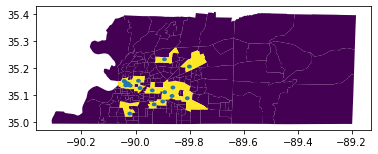

In [213]:
ax = city_shp.plot(column = 'anchor_institution')
anchor_institutions_buffer_wgs.plot(ax = ax)
plt.show()

###### Subsidized housing

In [214]:
### LIHTC
lihtc = pd.read_csv(input_path+'LowIncome_Housing_Tax_Credit_Properties.csv')

### Public housing
pub_hous = pd.read_csv(input_path+'Public_Housing_Buildings.csv')

/Users/timothythomas/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (90,98,103,109,110,113,114) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/timothythomas/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (99,104,109) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [215]:
# Convert to geodataframe
lihtc = gpd.GeoDataFrame(lihtc, geometry=[Point(xy) for xy in zip (lihtc['X'], lihtc['Y'])])
pub_hous = gpd.GeoDataFrame(pub_hous, geometry=[Point(xy) for xy in zip (pub_hous['X'], pub_hous['Y'])])

### Clip point to only region of interest
### LIHTC
lihtc = lihtc[lihtc['geometry'].within(city_poly.loc[0, 'geometry'])].reset_index(drop = True)

### Public housing
pub_hous = pub_hous[pub_hous['geometry'].within(city_poly.loc[0, 'geometry'])].reset_index(drop = True)

### merge datasets
presence_ph_LIHTC = lihtc[['geometry']].append(pub_hous[['geometry']])

In [216]:
### check whether census tract contains public housing or LIHTC station
### and create public housing flag
city_shp['presence_ph_LIHTC'] = city_shp.intersects(presence_ph_LIHTC.unary_union)

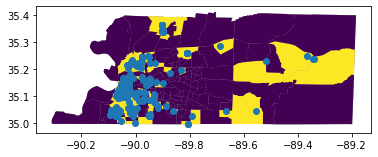

In [217]:
ax = city_shp.plot(color = 'grey')
city_shp.plot(ax = ax, column = 'presence_ph_LIHTC')
presence_ph_LIHTC.plot(ax = ax)
plt.show()

In [218]:
city_shp['GEOID'] = city_shp['GEOID'].astype('int64')

In [219]:
census = census.merge(city_shp[['GEOID', 'rail', 'anchor_institution', 'presence_ph_LIHTC', 'geometry']], right_on = 'GEOID', left_on = 'FIPS')

### Export csv file

In [220]:
census.to_csv(output_path+city_name+'_database.csv')